### Tracing test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

Start well with `tsandQ=[(0, -Q), (100, Q), (200, -Q)]`

In [2]:
Q = 100
npor = 0.3
k = 10
H = 10
T = k * H
Ss = 1e-4
S = Ss * H
ml = ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.01, tmax=1000, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q), (300, -Q)], rw=0.3)
ml.solve()
trace = timtracelines(ml, 0.3, 0, 0, tstartend=[0, 100, 300, 400], tstartoffset=0.01, deltlist=10, 
                      nstepmax=120, hstepmax=2, correctionstep=True)
xyzt = trace['trace']

self.neq  1
solution complete
reached maximum time tmax
reached element of type well


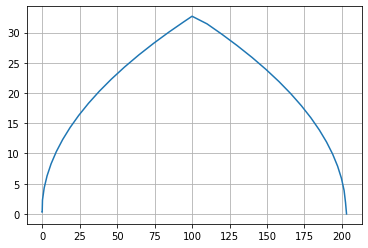

In [3]:
plt.plot(xyzt[:, 3], xyzt[:, 0])
plt.grid()

In [4]:
xyzt

array([[3.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.00000000e-01, 0.00000000e+00, 0.00000000e+00, 1.00000000e-02],
       [2.30000000e+00, 0.00000000e+00, 0.00000000e+00, 2.10098519e-01],
       [4.30000000e+00, 0.00000000e+00, 0.00000000e+00, 1.33999279e+00],
       [6.30000000e+00, 0.00000000e+00, 0.00000000e+00, 3.26698097e+00],
       [8.30000000e+00, 0.00000000e+00, 0.00000000e+00, 5.96745556e+00],
       [1.03000000e+01, 0.00000000e+00, 0.00000000e+00, 9.43303664e+00],
       [1.23000000e+01, 0.00000000e+00, 0.00000000e+00, 1.36597947e+01],
       [1.43000000e+01, 0.00000000e+00, 0.00000000e+00, 1.86455708e+01],
       [1.63000000e+01, 0.00000000e+00, 0.00000000e+00, 2.43890528e+01],
       [1.83000000e+01, 0.00000000e+00, 0.00000000e+00, 3.08893853e+01],
       [2.03000000e+01, 0.00000000e+00, 0.00000000e+00, 3.81459779e+01],
       [2.23000000e+01, 0.00000000e+00, 0.00000000e+00, 4.61584064e+01],
       [2.43000000e+01, 0.00000000e+00, 0.00000000e

In [5]:
Q = -100
npor = 0.3
k = 10
H = 10
T = k * H
Ss = 1e-4
S = Ss * H
ml = ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.01, tmax=100, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, Q)], rw=0.3)
ml.solve()

self.neq  1
solution complete


reached maximum time tmax


18

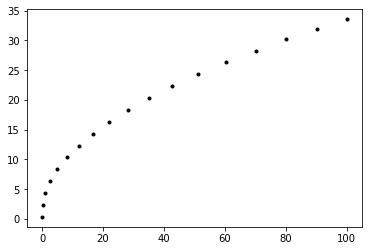

In [6]:
timtrace = timtraceline(ml, 0.3, 0, 0, tstart=0.01, delt=10, tmax=100, nstepmax=120, hstepmax=2)
xyzt1 = timtrace['trace']
plt.plot(xyzt1[:, 3], xyzt1[:, 0], 'k.')
len(xyzt1)

delt: 1.6666666666666667
delt: 2.0
delt: 2.4
delt: 2.88
delt: 3.456
delt: 4.1472
delt: 4.97664
delt: 5.9719679999999995
delt: 7.166361599999999
delt: 8.599633919999999
delt: 10.319560703999999
delt: 12.383472844799998
delt: 14.860167413759998
delt: 17.832200896511996
delt: 21.398641075814393
delt: 25.67836929097727
delt: 30.814043149172722
reached maximum time tmax


18

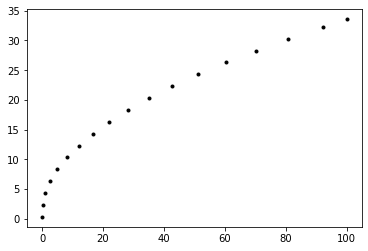

In [7]:
timtrace = timtraceline2(ml, 0.3, 0, 0, tstart=0.01, tmax=100, nstepmax=120, hstepmax=2,
                         delt=2, deltmin=1, deltmax=100, tmult=1.1)
xyzt1 = timtrace['trace']
plt.plot(xyzt1[:, 3], xyzt1[:, 0], 'k.')
len(xyzt1)

In [8]:
timtrace = timtraceline(ml, 0.3, 0, 0, tstart=0.01, delt=1, tmax=100, nstepmax=110)
xyztnc = timtrace['trace']

reached maximum time tmax


\begin{equation}
Q_r = -T\frac{\partial h}{\partial r} = -T\frac{\text{d} h}{\text{d} u}\frac{\partial u}{\partial r} = -\frac{Q}{2\pi} \frac{1}{r}\exp(-u)
\end{equation}
\begin{equation}
u =  \frac{S r^2}{4T(t-t_0)}
\end{equation}

In [9]:
def vxytheis(t, xy):
    x, y = xy
    r = np.sqrt(x ** 2 + y ** 2)
    u = S * r ** 2 / (4 * T * t)
    Qr = -Q / (2 * np.pi) / r * np.exp(-u)
    vr = Qr / (H * npor)
    vx = vr * x / r
    vy = vr * y / r
    return np.array([vx, vy])

In [10]:
from scipy.integrate import solve_ivp
t = np.linspace(0.01, 100, 100)
path0 = solve_ivp(vxytheis, (0.01, 100), y0=[0.3, 0], t_eval=t)

# Velocities in multi-layer system

In [11]:
Q = 100
npor = 0.3
k = 10
H = 10
Hstar = 2
c = 1000
T = k * H
Ss = 1e-4
S = Ss * H
ml = ModelMaq(kaq=[k, k], z=[2 * H + Hstar, H + Hstar, H, 0], c=[c], Saq=[Ss], tmin=1, tmax=100, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, Q)], layers=0)
ml.solve()

self.neq  1
solution complete


In [12]:
timtrace = timtraceline(ml, 20, 20, 4, tstart=1, delt=1, tmax=50, nstepmax=50)

reached maximum time tmax


In [13]:
timtrace

{'trace': array([[20.        , 20.        ,  4.        ,  1.        ],
        [19.99870023, 19.99870023,  4.00046088,  2.        ],
        [19.99733911, 19.99733911,  4.00092661,  3.        ],
        [19.99595617, 19.99595617,  4.00139277,  4.        ],
        [19.99456225, 19.99456225,  4.00185903,  5.        ],
        [19.99316177, 19.99316177,  4.00232537,  6.        ],
        [19.99175693, 19.99175693,  4.00279177,  7.        ],
        [19.990349  , 19.990349  ,  4.00325824,  8.        ],
        [19.98893876, 19.98893876,  4.00372478,  9.        ],
        [19.98752675, 19.98752675,  4.0041914 , 10.        ],
        [19.98611332, 19.98611332,  4.00465808, 11.        ],
        [19.98469872, 19.98469872,  4.00512482, 12.        ],
        [19.98328321, 19.98328321,  4.00559164, 13.        ],
        [19.9818669 , 19.9818669 ,  4.00605853, 14.        ],
        [19.98044992, 19.98044992,  4.00652548, 15.        ],
        [19.97903238, 19.97903238,  4.00699251, 16.        ],

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

In [15]:
Q = 100
npor = 0.3
k = 10
H = 10
Hstar = 2
c = 1000
T = k * H
Ss = 1e-4
S = Ss * H
ml = Model3D(kaq=10, z=[20, 15, 10, 5, 0], tmin=0.01, tmax=1000)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, Q)], layers=1, rw=0.1)
ml.solve()

self.neq  1
solution complete


In [16]:
timtrace = timtraceline(ml, 20, 20, 16, tstart=1, delt=5, tmax=200, nstepmax=40, hstepmax=2)
timtrace

reached element of type well


{'trace': array([[ 20.        ,  20.        ,  16.        ,   1.        ],
        [ 19.64719685,  19.64719685,  15.98576935,   6.        ],
        [ 19.2851206 ,  19.2851206 ,  15.96867273,  11.        ],
        [ 18.91748553,  18.91748553,  15.94968563,  16.        ],
        [ 18.54439189,  18.54439189,  15.92869764,  21.        ],
        [ 18.16576208,  18.16576208,  15.9055246 ,  26.        ],
        [ 17.7814755 ,  17.7814755 ,  15.87994338,  31.        ],
        [ 17.39139523,  17.39139523,  15.85169619,  36.        ],
        [ 16.99537674,  16.99537674,  15.82048783,  41.        ],
        [ 16.59327174,  16.59327174,  15.78598071,  46.        ],
        [ 16.18493076,  16.18493076,  15.74778823,  51.        ],
        [ 15.77020514,  15.77020514,  15.70546646,  56.        ],
        [ 15.34894909,  15.34894909,  15.65850389,  61.        ],
        [ 14.921022  ,  14.921022  ,  15.60630903,  66.        ],
        [ 14.48629099,  14.48629099,  15.54819499,  71.        ],
 

reached maximum number of steps
reached maximum number of steps
reached maximum number of steps
reached element of type well
reached element of type well
reached element of type well
reached element of type well
reached element of type well
reached element of type well
reached element of type well


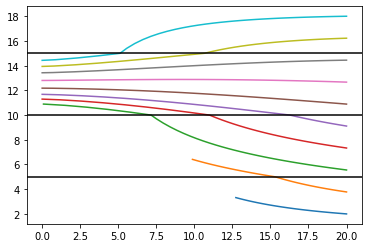

In [17]:
zstart = np.linspace(2, 18, 10)
for zs in zstart:
    timtrace = timtraceline(ml, 20, 20, zs, tstart=1, delt=5, tmax=200, nstepmax=40, hstepmax=2)
    xyzt = timtrace['trace']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [5, 10, 15]:
    plt.axhline(y, color='k')

In [18]:
Q = 100
npor = 0.3
k = 10
H = 10
Hstar = 2
c = 1000
T = k * H
Ss = 1e-4
S = Ss * H
ml = Model3D(kaq=10, z=[20, 15, 10, 5, 0], tmin=0.01, tmax=1000)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q)], layers=1, rw=0.1)
ml.solve()

self.neq  1
solution complete


reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax


(-1.0188327772671186, 23.595488322829492, 1.6083097813674625, 20.8246646792316)

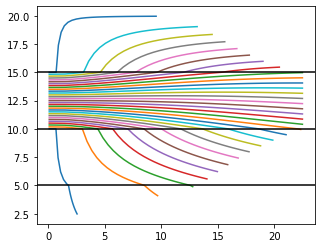

In [19]:
zstart = np.linspace(10.01, 14.99, 31)
xyztend1 = []
for zs in zstart:
    timtrace = timtraceline(ml, 0.1, 0.1, zs, tstart=0.01, delt=5, tmax=100, nstepmax=40, hstepmax=2)
    xyzt = timtrace['trace']
    xyztend1.append(xyzt[-1])
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [5, 10, 15]:
    plt.axhline(y, color='k')
plt.axis('scaled')
#plt.savefig('/Users/mark/Downloads/injection_to_erik.png')

reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax


(-0.4501072796203901,
 23.85149687554299,
 -1.0000000000000004,
 20.999999999999996)

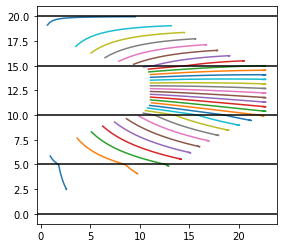

In [20]:
xyztend2 = []
for xyzts in xyztend1:
    xs, ys, zs, ts = xyzts
    timtrace = timtraceline(ml, xs, ys, zs, tstart=100 + 0.01, delt=5, tmax=200, nstepmax=40, hstepmax=2)
    xyzt = timtrace['trace']
    xyztend2.append(xyzt[-1])
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [0, 5, 10, 15, 20]:
    plt.axhline(y, color='k')
plt.axis('scaled')

In [21]:
w.headinside(200)

array([[-1.87847186]])

### Theis well

In [22]:
Q = 100 # injection
npor = 0.3
k = 10
H = 10
T = k * H
Ss = 1e-4
S = Ss * H
ml = ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.001, tmax=1000, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q), (200, -Q), (300, Q)])
ml.solve()

self.neq  1
solution complete


ts, zs 0 1
reached maximum time tmax
ts, zs 100 1.0
reached maximum time tmax
ts, zs 200 1.0
reached maximum time tmax
ts, zs 300 1.0
reached maximum time tmax


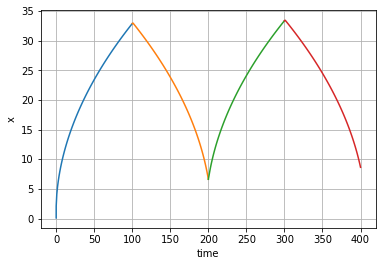

In [23]:
xs, ys, zs = 0.1, 0, 1
for ts in [0, 100, 200, 300]:
    print('ts, zs', ts, zs)
    timtrace = timtraceline(ml, xs, ys, zs, tstart=ts + 0.002, delt=1, tmax=ts + 100, nstepmax=200, hstepmax=2)
    xyzt = timtrace['trace']
    xs, ys, zs = xyzt[-1, :3]
    plt.plot(xyzt[:, 3], xyzt[:, 0])
plt.xlabel('time')
plt.ylabel('x')
plt.grid()

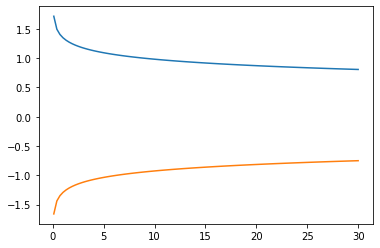

In [24]:
x = np.linspace(0.1, 30, 100)
h = ml.headalongline(np.linspace(0.1, 30, 100), 0, 100 - 1e-8)
plt.plot(x, h[0, 0])
h = ml.headalongline(np.linspace(0.1, 30, 100), 0, 200 - 1e-8)
plt.plot(x, h[0, 0])